# Tutorial 2a: Gluon Dataset - Introduction to non-linear Regression using Tensorflow

## Source

https://github.com/rabah-khalek/TF_tutorials

## Learning Goals##
This notebook will serve as an introduction to the non-linear regression as well as the new extremely powerful TensorFlow library for Machine Learning (ML) from Google. We will also learn how to use the versatile Pandas package for handling data.


## Overview##
Throughout, we will work with the [Gluon dataset](https://github.com/rabah-khalek/TF_tutorials/tree/master/PseudoData). It is computed using the [LHAPDF](https://lhapdf.hepforge.org) open source code, a general purpose C++ and python interpolator, used for evaluating PDFs from discretised data files.

Here is the description of the Gluon dataset we will be playing around with for this notebook:
>A gluon is an elementary particle that acts as the exchange particle (or gauge boson) for the strong force between quarks. It is analogous to the exchange of photons in the electromagnetic force between two charged particles. 

>In technical terms, gluons are vector gauge bosons that mediate strong interactions of quarks in quantum chromodynamics (QCD). Gluons themselves carry the color charge of the strong interaction. This is unlike the photon, which mediates the electromagnetic interaction but lacks an electric charge. Gluons therefore participate in the strong interaction in addition to mediating it, making QCD significantly harder to analyze than QED (quantum electrodynamics).

>Because of the inherent non-perturbative nature of partons(quarks and gluon in general) which cannot be observed as free particles, parton densities cannot be calculated using perturbative QCD.
Parton distribution functions are obtained by fitting observables to experimental data; they cannot be calculated using perturbative QCD.

> The parton density function $f_i(x,Q)$ gives the probability of finding in the proton a parton of flavour $i$ (quarks or gluon) carrying a fraction $x$ of the proton momentum with $Q$ being the energy scale of the hard interaction. Cross sections are calculated by convo- luting the parton level cross section with the PDFs. Since QCD does not predict the parton content of the proton, the shapes of the PDFs are determined by a fit to data from experimental observables in various processes, using the DGLAP evolution equation.

> This PseudoData is computed from such fit performed by the [NNPDF collaboration](http://nnpdf.mi.infn.it) that determines the structure of the proton using contemporary methods of artificial intelligence. NNPDF determines PDFs using as an unbiased modeling tool Neural Networks, trained using Genetic Algorithms and recently stochastic Gradient descent, and used to construct a Monte Carlo representation of PDFs and their uncertainties: a probability distribution in a space of functions.

We Will consider the computed pseudodata to be the *truth* that we're trying to *discover*, but what we will fit actually is the *smeared truth* (noise added on top based on the uncertainties given).

## Importing the Gluon data set with Pandas

There are four separate datasets each containing a total of 1000 gluon PDF predictions computed between $x=[x_{min},1]$ all for $Q=2\,GeV$; where:
- $x_{min} = 10^{-3}$ for `filename1`
- $x_{min} = 10^{-4}$ for `filename2`
- $x_{min} = 10^{-5}$ for `filename3`
- $x_{min} = 10^{-6}$ for `filename4`
  
1) In what follows (the first cell), we use Pandas to import all datapoints from text files  
2) We use `sklearn` to split the data into a random 800 x-points for training and the rest 200 x-points for testing.  
3) Although it might be not crucial for our specific problem but we do scale the x inputs to help the minimization (see below)  

## Why do we scale the input of a Neural Network?

Given the use of small weights in the model and the use of error between predictions and expected values, the scale of inputs and outputs used to train the model are an important factor. Unscaled input variables can result in a slow or unstable learning process, whereas unscaled target variables on regression problems can result in exploding gradients causing the learning process to fail.

The input variables are those that the network takes on the input or visible layer in order to make a prediction.

A good rule of thumb is that input variables should be small values, probably in the range of 0-1 or standardized with a zero mean and a standard deviation of one.

Whether input variables require scaling depends on the specifics of your problem and of each variable.


In [1]:
# Importing the Gluon Data set

## Loading all needed libraries for this tutorial
import sys, os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
#Commnent the next line on to turn off warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
# suppress tflow compilation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# The datasets needed are computed by the `ComputeGluon.py` script in PseudoData
filename1='../../PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-3.dat' 
filename2='../../PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-4.dat' 
filename3='../../PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-5.dat' 
filename4='../../PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-6.dat' 

#header to skip
lines_to_skip = 5

# defining the columns
columns=["x", "gluon_cv", "gluon_sd"]

# Loading data from txt file
df = pd.read_csv(filename1, 
                 sep="\s+", 
                 skiprows=lines_to_skip, 
                 usecols=[0,1,2], 
                 names=columns)

#the random seed, changing it for different initialization of parameters.
seed=1991924
np.random.seed(seed)
tf.set_random_seed(seed)

#splitting data randomly to train and test using the sklearn library
df_train, df_test = train_test_split(df, test_size=0.2)

# sort the splitted data according to their x values
df_train = df_train.sort_values("x")
df_test = df_test.sort_values("x")

#Shaping the x values for the scaler
train_inputs=[]
for x in df_train['x']:
    train_inputs.append([x])

test_inputs=[]
for x in df_test['x']:
    test_inputs.append([x])


#Scaling input features to help the minimizer.
train_scaler = StandardScaler()
train_scaler.fit(train_inputs)
test_scaler = StandardScaler()
test_scaler.fit(test_inputs)

print("Data parsing is done!")


Data parsing is done!


## Building a Neural Network using TensorFlow##

[arXiv:1910.01545](https://arxiv.org/abs/1910.01545):
>A finite Neural Network is capable of universally approximating a non- linear operator uniformly over the function space on which it operates

The idea is to fit the gluon distribution (that cannot be calculated using perturbative QCD) using a neural network.

We're building here the Neural network of 1 input, 1 output, and 1 hidden layer in two ways:
- Building it ourselves in `USER_NN`
- TensorFlow built-in Neural Network in `TF_NN`

We consider here a single layered neural network to be enough for our exercice here, but feel free to experiment with *deeper* architectures.

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import sys

# User defined Neural Network
def USER_NN(x, weights, biases):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer


#a built-in way to define a neural network
def TF_NN(inputs, n_neurones, n_outputs=1):

    hidden_layer = tf.layers.dense( x, 
                                    n_neurones, 
                                    activation=tf.nn.sigmoid,
                                    reuse=tf.AUTO_REUSE)

    NN = tf.layers.dense(hidden_layer, n_outputs,name='outputs',reuse=tf.AUTO_REUSE)

    return NN




If you decide to use the USER_NN, you have to specify here the number of inputs, outputs and hidden layer neurones.

You can try different architectures by modifying the n_hidden_1

In [5]:
n_hidden_1 = 20
n_input = 1 
n_target = 1

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_target]))}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_target]))
    }

## Data modeling and fitting

source: https://www-cdf.fnal.gov/physics/statistics/recommendations/modeling.html

The next cell contain the bulk of the minimization routine.

Before we dive into it, let's review some important concepts applied:

### Chi Square
One of the most frequently occurring problems in high-energy physics is to compare an observed distribution with a prediction, for example from a simulation. Indeed, an analysis might be designed to extract some physical parameter from the simulation or prediction which best fits the data.  

For data points with Gaussian errors, the likelihood of a gaussian distribution is:

$$ L = \prod_i \frac{1}{\sqrt(2\pi\sigma^2)} e^{-\frac{(m_i - d_i)^2}{2\sigma_i^2}}$$

hence the following [MLE](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (maximum (log) likelihood estimation) gives:

$$ \chi^2 = \sum_i^N \left(\frac{m_i - d_i}{\sigma_i} \right)^2$$

where $m_i$ is the model evaluated at point $x_i$, $d_i$ is the data, and $\sigma_i$ is the uncertainty on the data at this point.

The chi square expresses the deviation of the observed data from the fit, weighted inversely by the uncertainties in the individual points. The chi-square can be either used to test how well a particular model describes the data or, if the prediction is a function of some parameters then the optimal values of the parameters can be found by minimizing the chi square.

The main pitfall here is that the purely Gaussian case is in fact rather rare, usually because the data points come from Poisson-distributed numbers of events which are not well approximated by Gaussian distributions. Using a standard chi square approach in such cases leads to biased estimates of both the parameters and their uncertainties.

Nevertheless we will assume here that our datapoints' errors are Gaussian, and we will use the Chi-square as the loss function in this tutorial.

## Exercices
Try modifying the:
- Amount of **training epochs** (100k for instance). Why the minimizer stops? What does it mean to over fit and is `max_rising_epochs` enough to prevent it?
- **Activation functions**: relu, sigmoid, tanh (go back to the definition of the NN above)
- **Architectures**: Increase the number of neurones in the hidden layer, do you notice any change in the flexibility of the Neural Network?
- **Learning rates**: for the same settings. How does the convergence speed change?
- **Optimizers**: like `AdagradOptimizer` for example... (see other options here: https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/AdagradOptimizer)
- repeat the exercice with different x intervals by changing the file name in first cell. What happens in the low-x region?

In [6]:
from termcolor import colored

training_epochs = 100000
max_rising_epochs=5000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 1000

x = tf.placeholder("float", [None, 1])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train["x"])
N_test = len(df_test["x"])

predictions = USER_NN(x, weights, biases)
#predictions = TF_NN(x, 20, 1)

cost = tf.reduce_mean(tf.square((y-predictions)/sigma)) #/sigma

eta = 0.0001
optimizer = tf.train.AdamOptimizer(learning_rate=eta).minimize(cost)
#optimizer = tf.train.AdagradOptimizer(learning_rate=eta).minimize(cost)

train_x = np.array(train_scaler.transform(train_inputs)).reshape(N_train,1)
train_y = np.array(df_train["gluon_cv"]).reshape(N_train,1)
train_sigma = np.array(df_train["gluon_sd"]).reshape(N_train,1)
train_y += np.random.normal(0, train_sigma)

test_x = np.array(test_scaler.transform(test_inputs)).reshape(N_test,1)
test_y = np.array(df_test["gluon_cv"]).reshape(N_test,1)
test_sigma = np.array(df_test["gluon_sd"]).reshape(N_test,1)
test_y += np.random.normal(0, test_sigma)

prev_test_cost =np.inf
prev_epoch=0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    avg_cost = 0.0
    for epoch in range(training_epochs):

        _, c = sess.run([optimizer, cost], 
                        feed_dict={
                            x: train_x, 
                            y: train_y, 
                            sigma: train_sigma
                        })
        avg_cost = c/N_train
        
        test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})/N_test
        
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "| Train cost=", "{:.9f}".format(avg_cost), "| Test cost=", "{:.9f}".format(test_cost))
                         
        if test_cost > prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
            print(colored("\n The minimization stopped...","red"))
            print("Epoch:", '%04d' % (epoch+1), "| Best Train cost=", "{:.9f}".format(avg_cost), "| Test cost=", "{:.9f}".format(test_cost))
            print("Overfitting regime was about to start at epoch: ",epoch)
            break
            
        elif test_cost < prev_test_cost:
            prev_test_cost=test_cost
            prev_epoch=epoch
        
    
    print("Optimization Finished!")
    predictions_values = sess.run(predictions, 
                        feed_dict={
                            x: train_x, 
                            y: train_y
                        })
    
 


Epoch: 0001 | Train cost= 79.078286133 | Test cost= 1543.538437500
Epoch: 1001 | Train cost= 36.269050293 | Test cost= 698.302109375
Epoch: 2001 | Train cost= 14.005280762 | Test cost= 263.299726562
Epoch: 3001 | Train cost= 3.910499268 | Test cost= 69.121479492
Epoch: 4001 | Train cost= 0.666202850 | Test cost= 8.972670898
Epoch: 5001 | Train cost= 0.153834743 | Test cost= 0.812429428
Epoch: 6001 | Train cost= 0.118467350 | Test cost= 0.677909241
Epoch: 7001 | Train cost= 0.101192942 | Test cost= 0.563777504
Epoch: 8001 | Train cost= 0.083658810 | Test cost= 0.435121384
Epoch: 9001 | Train cost= 0.066988482 | Test cost= 0.326055870
Epoch: 10001 | Train cost= 0.051888452 | Test cost= 0.240685501
Epoch: 11001 | Train cost= 0.039420333 | Test cost= 0.179262943
Epoch: 12001 | Train cost= 0.030441108 | Test cost= 0.141493235
Epoch: 13001 | Train cost= 0.024548671 | Test cost= 0.121547642
Epoch: 14001 | Train cost= 0.020432816 | Test cost= 0.108942814
Epoch: 15001 | Train cost= 0.017094113 

## Plotting output

Here's a simple plotting script where:
- $t_{g}^{train}$ represents the truth value of the training set, i.e the values taken from the txt file.
- $d_{g}^{train}$ are the smeared data we actually fit.
- $NN_{g}$ is the output of our Neural Network.

You can uncomment several other information like: $d_{g}^{test}$, the error bars used, etc.

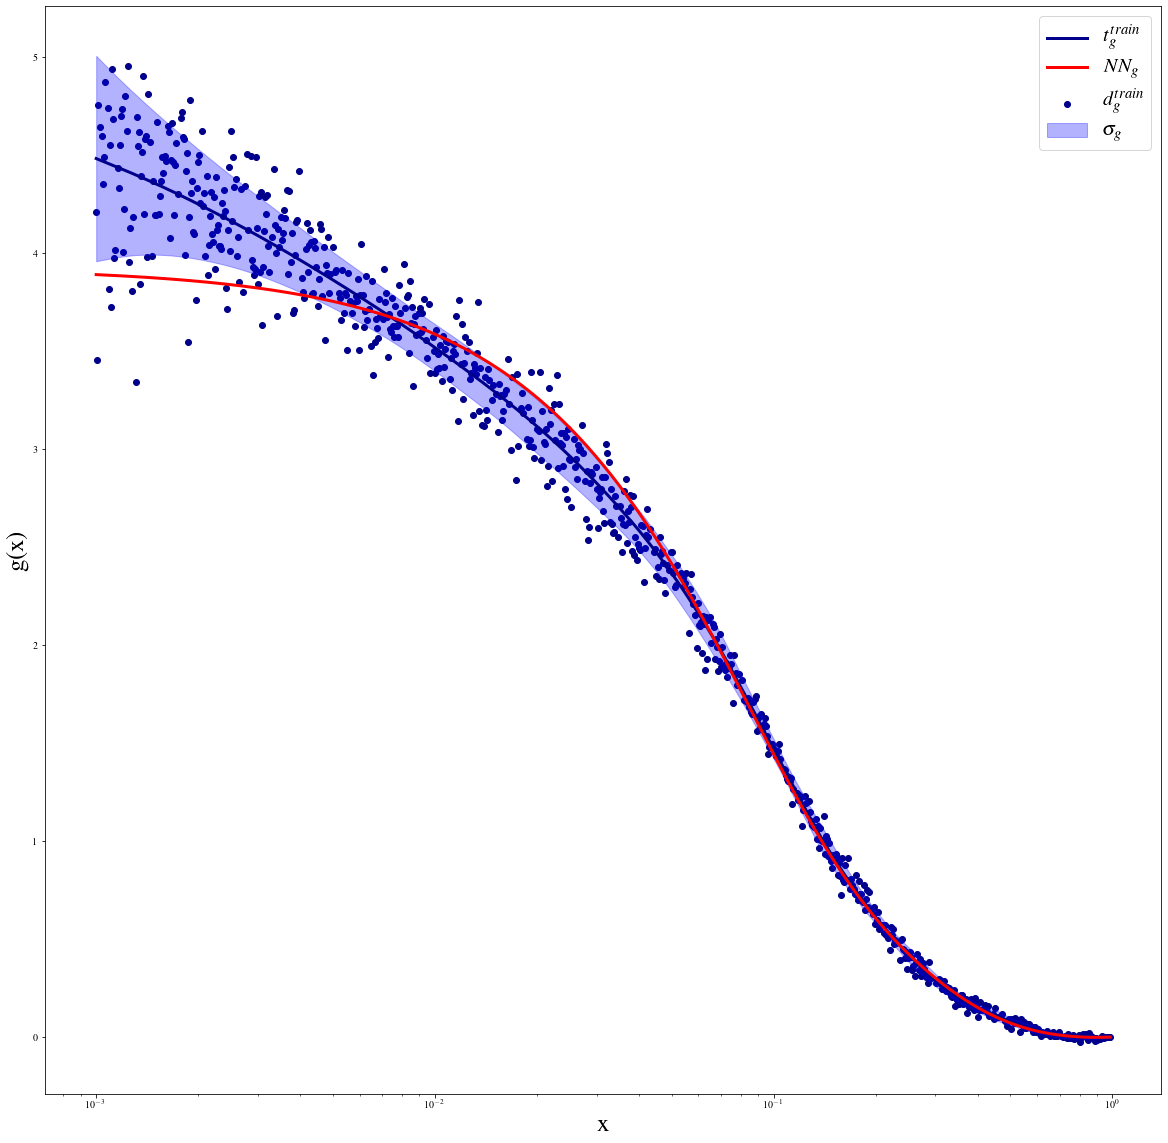

In [7]:
#predictions = np.array(predictions_values.eval(session=tf.Session()))

plt.figure(figsize=(20,20))
ax = plt.subplot(111)
ax.plot(df_train["x"],df_train["gluon_cv"],color='darkblue',label='$t_{g}^{train}$', lw=3)
#ax.plot(df_test["x"],df_test["gluon_cv"],color='darkgreen',label='$t_{g}^{test}$',alpha=0.3)

ax.scatter(df_train["x"],train_y, marker="o", color='darkblue',alpha=1.,label='$d_{g}^{train}$')
#ax.scatter(df_test["x"],test_y,marker="o",  color = 'darkgreen',alpha=1.,label='$d_{g}^{test}$')

#ax.errorbar(df_train["x"],train_y,yerr=train_sigma,color='darkblue',label='$d_{g}^{train}$',alpha=0.3)
#ax.errorbar(df_test["x"],test_y,yerr=test_sigma,color='darkgreen',label='$d_{g}^{test}$',alpha=0.3)

ax.plot(df_train["x"],predictions_values,color='red',label='$NN_{g}$', lw=3)
ax.fill_between(df_train["x"],df_train["gluon_cv"]+df_train["gluon_sd"],
                df_train["gluon_cv"]-df_train["gluon_sd"] ,color='blue', 
                alpha=0.3, label='$\sigma_{g}$')

#df_train.plot(kind='line',x='x',y=['gluon_cv'], yerr='gluon_sd',color=['red'], ax=ax)
ax.set_xscale('log')
ax.set_ylabel(r'g(x)',fontsize=25)
ax.set_xlabel(r'x',fontsize=25)
ax.legend(loc='best',fontsize=20)
plt.show()